<a href="https://colab.research.google.com/github/NichBry25/BitcoinPricePrediction/blob/main/BTCForecasting_GRU_Based_DeepVAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Ensures results are replicable

import os
os.environ["PYTHONHASHSEED"] = "42"
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import random

In [3]:
# Ensures results are replicable

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [4]:
df = pd.read_csv('btc_forecasting_dataset3.csv')

In [5]:
df

,Date,btc_price,open,high,low,volume,spx_price,xau_price,vix_price,dxy_price,...,xau_logret_lag3,xau_logret_lag7,vix_logret_lag1,vix_logret_lag3,vix_logret_lag7,dxy_logret_lag1,dxy_logret_lag3,dxy_logret_lag7,btc_ma50,btc_ma200
0,2015-07-20,277.7,273.2,278.9,271.8,46600.0,2128.30,1096.95,12.25,98.03,...,-0.009696,-0.005134,0.000000,-0.013300,-0.191274,0.000000,0.001943,0.008606,252.782,246.4990
1,2015-07-21,275.1,277.7,281.0,274.2,49050.0,2119.20,1101.41,12.22,97.33,...,0.000000,-0.002135,0.024795,0.000000,-0.038875,0.001736,0.000000,-0.002274,253.822,246.2985
2,2015-07-22,276.5,275.1,277.4,273.1,41970.0,2114.20,1093.45,12.12,97.60,...,0.000000,-0.005102,-0.002452,0.000000,-0.010526,-0.007166,0.000000,0.005469,254.838,246.2455
3,2015-07-23,275.5,276.5,277.9,274.5,35660.0,2102.20,1090.80,12.64,97.11,...,-0.033306,-0.003922,-0.008217,0.024795,-0.088455,0.002770,0.001736,0.005132,255.836,246.2995
4,2015-07-24,288.4,275.5,289.8,274.3,74360.0,2079.70,1099.10,13.74,97.24,...,0.004058,-0.009696,0.042009,-0.002452,-0.013300,-0.005033,-0.007166,0.001943,257.120,246.3675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3752,2025-10-27,114108.0,114553.9,116307.5,113868.0,70790.0,6875.16,3981.59,15.79,98.78,...,-0.003416,0.024755,0.000000,-0.055256,-0.130922,0.000000,0.000101,0.001624,114272.866,108948.3695
3753,2025-10-28,112905.8,114110.3,116076.7,112266.9,52490.0,6890.89,3952.58,16.42,98.67,...,0.000000,-0.054579,-0.036074,0.000000,-0.019945,-0.001720,0.000000,0.003443,114289.614,109095.8330
3754,2025-10-29,110024.6,112904.7,113628.7,109506.4,66990.0,6890.59,3930.38,16.92,99.22,...,0.000000,-0.007551,0.039123,0.000000,0.040038,-0.001114,0.000000,-0.000303,114259.776,109219.4925
3755,2025-10-30,108320.1,110024.9,111585.8,106371.4,80070.0,6822.34,4024.47,16.91,99.53,...,-0.032253,0.007810,0.029996,-0.036074,-0.072455,0.005559,-0.001720,0.000404,114146.908,109342.4210


Grouping columns with or without macroeconomic features based on number ("1" for WITHOUT, and "2" for WITH)

In [6]:
TARGET = 'btc_logret'

In [7]:
FEATURES_1 = [
    "btc_price", "open", "high", "low", "volume",
    "btc_ma50", "btc_ma200"
]

In [8]:
FEATURES_2 = [
    "btc_price","open","high","low","volume",
    "spx_price","xau_price","vix_price","dxy_price",
    "spx_logret","xau_logret","vix_logret","dxy_logret",
    "spx_logret_lag1","spx_logret_lag3","spx_logret_lag7",
    "xau_logret_lag1","xau_logret_lag3","xau_logret_lag7",
    "vix_logret_lag1","vix_logret_lag3","vix_logret_lag7",
    "dxy_logret_lag1","dxy_logret_lag3","dxy_logret_lag7",
    "btc_ma50","btc_ma200"
]

# Train - Val - Test Split

In [9]:
total_len = len(df)

In [10]:
train_end = int(total_len * 0.7)
val_end = int(total_len * 0.85)

train_df = df.iloc[:train_end].copy()
val_df   = df.iloc[train_end:val_end].copy()
test_df  = df.iloc[val_end:].copy()

In [11]:
train_df.shape

(2629, 29)

In [12]:
val_df.shape

(564, 29)

In [13]:
test_df.shape

(564, 29)

# Scale Features

In [14]:
scaler_1 = MinMaxScaler()

In [15]:
scaler_1.fit(train_df[FEATURES_1])

MinMaxScaler()

In [16]:
train_scaled_1 = scaler_1.transform(train_df[FEATURES_1])
val_scaled_1   = scaler_1.transform(val_df[FEATURES_1])
test_scaled_1  = scaler_1.transform(test_df[FEATURES_1])

In [17]:
scaler_2 = MinMaxScaler()

In [18]:
scaler_2.fit(train_df[FEATURES_2])

MinMaxScaler()

In [19]:
train_scaled_2 = scaler_2.transform(train_df[FEATURES_2])
val_scaled_2   = scaler_2.transform(val_df[FEATURES_2])
test_scaled_2  = scaler_2.transform(test_df[FEATURES_2])

In [20]:
# Target scaler
y_train_full = train_df[TARGET].values
y_val_full   = val_df[TARGET].values
y_test_full  = test_df[TARGET].values

In [21]:
target_scaler = StandardScaler()

In [22]:
target_scaler.fit(y_train_full.reshape(-1, 1))

StandardScaler()

In [23]:
y_train_scaled = target_scaler.transform(y_train_full.reshape(-1, 1)).ravel()
y_val_scaled   = target_scaler.transform(y_val_full.reshape(-1, 1)).ravel()
y_test_scaled  = target_scaler.transform(y_test_full.reshape(-1, 1)).ravel()

# Create Sequence

In [25]:
def make_sequence_data(values, target, lookback):
    X, y = [], []
    for i in range(lookback, len(values)):
        X.append(values[i - lookback:i])
        y.append(target[i])
    return np.array(X), np.array(y)

In [26]:
LOOKBACK = 60

In [27]:
X_train_1, y_train_1 = make_sequence_data(train_scaled_1, y_train_scaled, LOOKBACK)
X_val_1,   y_val_1   = make_sequence_data(val_scaled_1,   y_val_scaled,   LOOKBACK)
X_test_1,  y_test_1  = make_sequence_data(test_scaled_1,  y_test_scaled,  LOOKBACK)

In [28]:
X_train_2, y_train_2 = make_sequence_data(train_scaled_2, y_train_scaled, LOOKBACK)
X_val_2,   y_val_2   = make_sequence_data(val_scaled_2,   y_val_scaled,   LOOKBACK)
X_test_2,  y_test_2  = make_sequence_data(test_scaled_2,  y_test_scaled,  LOOKBACK)

In [29]:
y_test_unscaled = y_test_full[LOOKBACK:]

# Metrics

In [30]:
def calculate_performance_metrics(y_test, y_pred):
    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_test, y_pred)
    da   = np.mean((y_test * y_pred) > 0)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "DA": da}

# Modelling

In [31]:
from itertools import product

In [32]:
GRID = {
    "units": [50, 100],
    "learning_rate": [0.001, 0.003],
    "batch_size": [32, 64],
    "patience": [5, 10],
}

grid_combinations = list(product(
    GRID["units"],
    GRID["learning_rate"],
    GRID["batch_size"],
    GRID["patience"]
))

In [33]:
len(grid_combinations)

16

In [34]:
def gaussian_nll(y_true, y_pred):

    y_true = tf.reshape(y_true, (-1, 1))

    mean, raw_var = tf.split(y_pred, 2, axis=-1)
    var = tf.nn.softplus(raw_var) + 1e-6

    # NLL for Gaussian
    nll = 0.5 * (tf.math.log(var) + tf.square(y_true - mean) / var)

    return tf.reduce_mean(nll, axis=-1)

In [35]:
def build_deepvar_gru(input_shape, units, learning_rate):
    inputs = layers.Input(shape=input_shape)
    x = layers.GRU(units, return_sequences=True)(inputs)
    x = layers.GRU(units)(x)
    x = layers.Dense(25, activation='relu')(x)

    outputs = layers.Dense(2)(x)  # mean and log_variance

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=gaussian_nll
    )
    return model

In [36]:
results = []

In [38]:
for i, (units, lr, batch_size, patience) in enumerate(grid_combinations, 1):
  print(f"\n[{i}/{len(grid_combinations)}] "
        f"units={units}, lr={lr}, "
        f"batch={batch_size}, patience={patience}")

  ## WITHOUT MACRO
  model_1 = build_deepvar_gru(X_train_1.shape[1:], units, lr)

  model_1.fit(
      X_train_1, y_train_1,
      epochs = 50,
      batch_size = batch_size,
      validation_data = (X_val_1, y_val_1),
      callbacks = [
          callbacks.EarlyStopping(
              patience=patience,
              restore_best_weights=True
          )
      ],
      verbose=0
  )

  y_pred_1_full = model_1.predict(X_test_1)
  y_pred_1_scaled = y_pred_1_full[:, 0]
  y_pred_1 = target_scaler.inverse_transform(y_pred_1_scaled.reshape(-1, 1)).ravel()

  metrics_1 = calculate_performance_metrics(y_test_unscaled, y_pred_1)

  ## WITH MACRO
  model_2 = build_deepvar_gru(X_train_2.shape[1:], units, lr)

  model_2.fit(
      X_train_2, y_train_2,
      epochs = 50,
      batch_size = batch_size,
      validation_data = (X_val_2, y_val_2),
      callbacks = [
          callbacks.EarlyStopping(
              patience=patience,
              restore_best_weights=True
          )
      ],
      verbose=0
  )

  y_pred_2_full = model_2.predict(X_test_2)
  y_pred_2_scaled = y_pred_2_full[:, 0]
  y_pred_2 = target_scaler.inverse_transform(y_pred_2_scaled.reshape(-1, 1)).ravel()

  metrics_2 = calculate_performance_metrics(y_test_unscaled, y_pred_2)

  results.append({
      "units": units,
      "learning_rate": lr,
      "batch_size": batch_size,
      "patience": patience,

      "MSE_1": metrics_1['MSE'],
      'MSE_2': metrics_2['MSE'],

      "RMSE_1": metrics_1["RMSE"],
      "RMSE_2": metrics_2["RMSE"],

      "MAE_1": metrics_1["MAE"],
      "MAE_2": metrics_2["MAE"],

      "DA_1": metrics_1["DA"],
      "DA_2": metrics_2["DA"],

      "Macro Better MSE": metrics_2["MSE"] < metrics_1["MSE"],
      "Macro Better RMSE": metrics_2["RMSE"] < metrics_1["RMSE"],
      "Macro Better MAE": metrics_2["MAE"] < metrics_1["MAE"],
      "Macro Better DA": metrics_2["DA"] > metrics_1["DA"],
  })


[1/16] units=50, lr=0.001, batch=32, patience=5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

[2/16] units=50, lr=0.001, batch=32, patience=10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step

[3/16] units=50, lr=0.001, batch=64, patience=5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step

[4/16] units=50, lr=0.001, batch=64, patience=10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

[5/16] units=50, lr=0.003, batch=32, patience=5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

[6/16] units=50, lr=0.003, batch=32, patience=10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

[7/16] units=50, lr=0.003, batch=64, patience=5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

[8/16] units=50, lr=0.003, batch=64, patience=10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
16/1

# Results

In [39]:
results_df = pd.DataFrame(results)

In [40]:
results_df

,units,learning_rate,batch_size,patience,MSE_1,MSE_2,RMSE_1,RMSE_2,MAE_1,MAE_2,DA_1,DA_2,Macro Better MSE,Macro Better RMSE,Macro Better MAE,Macro Better DA
0,50,0.001,32,5,0.000565,0.000565,0.023779,0.023765,0.017067,0.017048,0.496032,0.486111,True,True,True,False
1,50,0.001,32,10,0.000563,0.000593,0.023719,0.024348,0.016939,0.017795,0.513889,0.488095,False,False,False,False
2,50,0.001,64,5,0.000562,0.000570,0.023713,0.023869,0.017013,0.017197,0.500000,0.476190,False,False,False,False
3,50,0.001,64,10,0.000625,0.000569,0.024999,0.023850,0.018512,0.017068,0.488095,0.488095,True,True,True,False
4,50,0.003,32,5,0.000563,0.000646,0.023730,0.025423,0.016939,0.018980,0.500000,0.488095,False,False,False,False
5,50,0.003,32,10,0.000572,0.000569,0.023909,0.023851,0.017149,0.017293,0.488095,0.505952,True,True,False,True
6,50,0.003,64,5,0.000566,0.000567,0.023797,0.023816,0.017041,0.017131,0.488095,0.496032,False,False,False,True
7,50,0.003,64,10,0.000579,0.000562,0.024059,0.023709,0.017553,0.016933,0.511905,0.462302,True,True,True,False
8,100,0.001,32,5,0.000559,0.000570,0.023647,0.023883,0.016937,0.017215,0.525794,0.496032,False,False,False,False
9,100,0.001,32,10,0.000557,0.000559,0.023611,0.023634,0.016925,0.016920,0.539683,0.513889,False,False,True,False


In [41]:
results_df.to_csv('deepvar_grid_results.csv') # Retraining the model is optional

In [42]:
best_without_macro = results_df.sort_values("RMSE_1").iloc[0]
best_with_macro = results_df.sort_values("RMSE_2").iloc[0]

In [43]:
best_without_macro

,9
units,100
learning_rate,0.001
batch_size,32
patience,10
MSE_1,0.000557
MSE_2,0.000559
RMSE_1,0.023611
RMSE_2,0.023634
MAE_1,0.016925
MAE_2,0.01692


In [44]:
best_with_macro

,9
units,100
learning_rate,0.001
batch_size,32
patience,10
MSE_1,0.000557
MSE_2,0.000559
RMSE_1,0.023611
RMSE_2,0.023634
MAE_1,0.016925
MAE_2,0.01692


In [45]:
macro_mse_win_rate = results_df["Macro Better MSE"].mean()
macro_mae_win_rate = results_df['Macro Better MAE'].mean()
macro_da_win_rate = results_df["Macro Better DA"].mean()

In [46]:
macro_mse_win_rate

np.float64(0.375)

In [47]:
macro_mae_win_rate

np.float64(0.375)

In [48]:
macro_da_win_rate

np.float64(0.3125)

# Retrain for Plotting

In [73]:
model_1 = build_deepvar_gru(X_train_1.shape[1:], int(best_without_macro['units']), best_without_macro['learning_rate'])

In [74]:
history_best_without_macro = model_1.fit(
    X_train_1, y_train_1,
    epochs = 50,
    batch_size = int(best_without_macro['batch_size']),
    validation_data = (X_val_1, y_val_1),
    callbacks = [
      callbacks.EarlyStopping(
          patience=best_without_macro['patience'],
          restore_best_weights=True
      )
    ],
    verbose=1
)

Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - loss: 0.5550 - val_loss: 0.1955
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - loss: 0.5307 - val_loss: 0.1971
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - loss: 0.5267 - val_loss: 0.2041
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - loss: 0.5239 - val_loss: 0.2179
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - loss: 0.5218 - val_loss: 0.2298
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - loss: 0.5252 - val_loss: 0.2208
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - loss: 0.5152 - val_loss: 0.2360
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 0.5151 - val_loss: 0.2102
Epoch 9/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - loss: 0.5104 - val_loss: 0.2144
Epoch 10/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - loss: 0.5096 - val_loss: 0.1960
Epoch 11/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - loss: 0.5076 - val_loss: 0.2259


In [78]:
y_pred_1_full = model_1.predict(X_test_1)
y_pred_1_scaled = y_pred_1_full[:, 0]
y_pred_1 = target_scaler.inverse_transform(y_pred_1_scaled.reshape(-1, 1)).ravel()

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


In [75]:
model_2 = build_deepvar_gru(X_train_2.shape[1:], int(best_with_macro['units']), best_with_macro['learning_rate'])

In [76]:
history_best_with_macro = model_2.fit(
    X_train_2, y_train_2,
    epochs = 50,
    batch_size = int(best_with_macro['batch_size']),
    validation_data = (X_val_2, y_val_2),
    callbacks = [
      callbacks.EarlyStopping(
          patience=int(best_with_macro['patience']),
          restore_best_weights=True
      )
    ],
    verbose=1
)

Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - loss: 0.5478 - val_loss: 0.1994
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - loss: 0.5328 - val_loss: 0.1558
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - loss: 0.5334 - val_loss: 0.1692
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - loss: 0.5271 - val_loss: 0.1891
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - loss: 0.5224 - val_loss: 0.1659
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - loss: 0.5218 - val_loss: 0.1322
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - loss: 0.5194 - val_loss: 0.1372
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - loss: 0.5147 - val_loss: 0.1517
Epoch 9/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - loss: 0.5119 - val_loss: 0.2049
Epoch 10/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - loss: 0.5199 - val_loss: 0.1643
Epoch 11/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - loss: 0.5097 - val_loss: 0.1463
Epoch 12/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 1

In [77]:
y_pred_2_full = model_2.predict(X_test_2)
y_pred_2_scaled = y_pred_2_full[:, 0]
y_pred_2 = target_scaler.inverse_transform(y_pred_2_scaled.reshape(-1, 1)).ravel()

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


# Price Reconstruction

In [60]:
actual_prices = test_df["btc_price"].iloc[LOOKBACK:].values

In [61]:
# Previous actual prices for each prediction step
prev_actual_prices = test_df["btc_price"].iloc[LOOKBACK-1:-1].values
prev_actual_prices = prev_actual_prices[:len(y_pred_1)]

In [62]:
# 1-step forecast: P_t^pred = P_{t-1}^actual * exp(predicted_logret_t)
pred_price_1 = prev_actual_prices * np.exp(y_pred_1[:len(prev_actual_prices)])
pred_price_2 = prev_actual_prices * np.exp(y_pred_2[:len(prev_actual_prices)])

In [63]:
# Align actual to same length
actual_prices = actual_prices[:len(pred_price_1)]

# Plotting

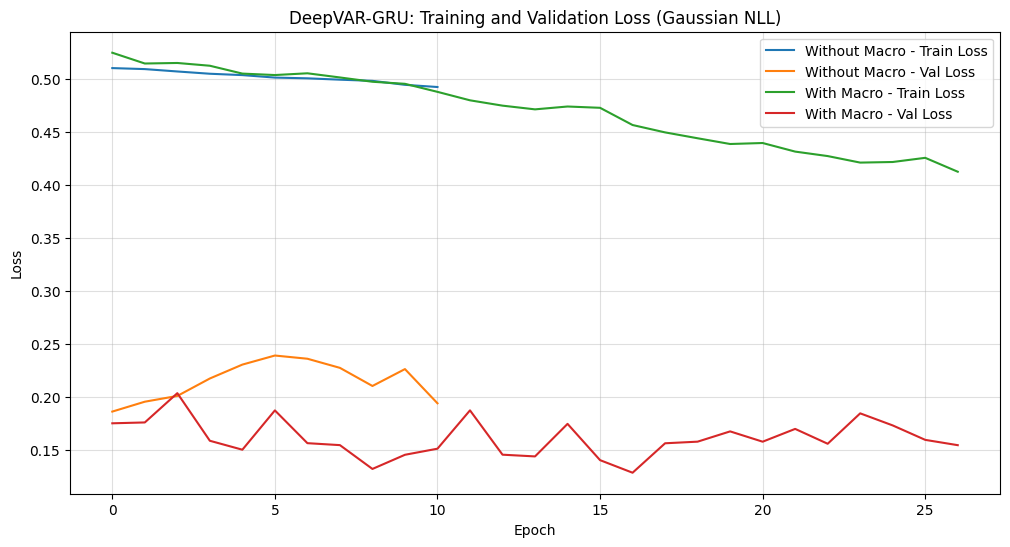

In [64]:
plt.figure(figsize=(12, 6))
plt.plot(history_best_without_macro.history["loss"], label="Without Macro - Train Loss")
plt.plot(history_best_without_macro.history["val_loss"], label="Without Macro - Val Loss")
plt.plot(history_best_with_macro.history["loss"], label="With Macro - Train Loss")
plt.plot(history_best_with_macro.history["val_loss"], label="With Macro - Val Loss")
plt.title("DeepVAR-GRU: Training and Validation Loss (Gaussian NLL)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()

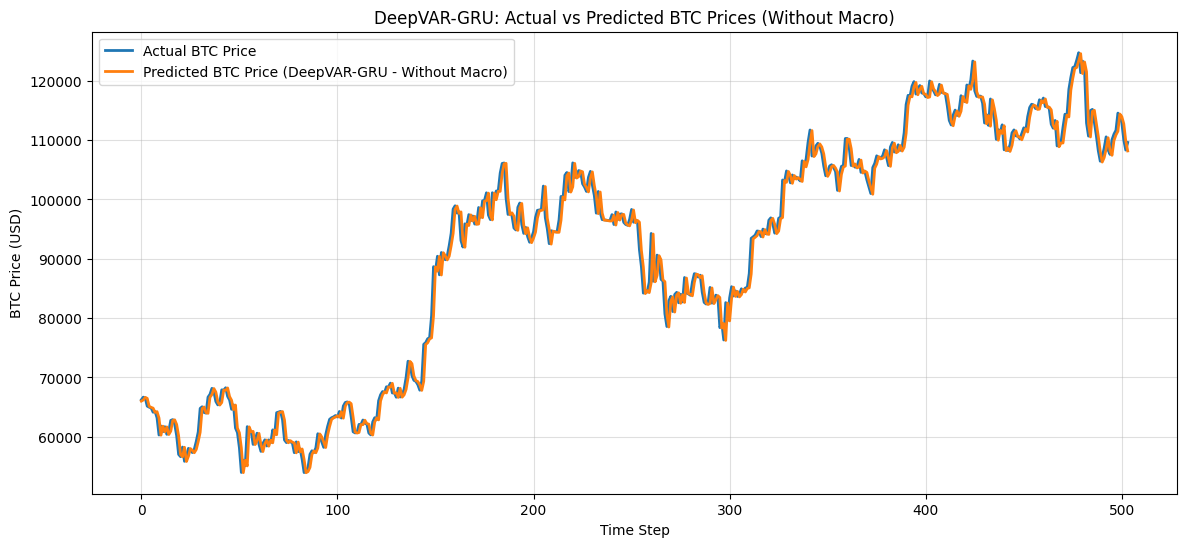

In [65]:
plt.figure(figsize=(14, 6))
plt.plot(actual_prices, label="Actual BTC Price", linewidth=2)
plt.plot(pred_price_1, label="Predicted BTC Price (DeepVAR-GRU - Without Macro)", linewidth=2)
plt.xlabel("Time Step")
plt.ylabel("BTC Price (USD)")
plt.title("DeepVAR-GRU: Actual vs Predicted BTC Prices (Without Macro)")
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()

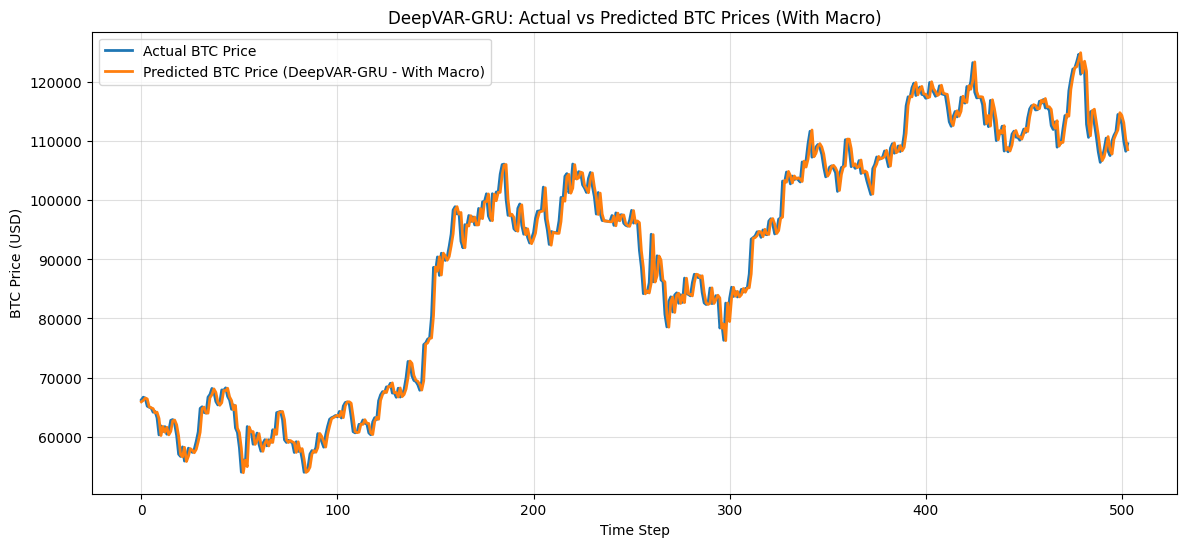

In [66]:
plt.figure(figsize=(14, 6))
plt.plot(actual_prices, label="Actual BTC Price", linewidth=2)
plt.plot(pred_price_2, label="Predicted BTC Price (DeepVAR-GRU - With Macro)", linewidth=2)
plt.xlabel("Time Step")
plt.ylabel("BTC Price (USD)")
plt.title("DeepVAR-GRU: Actual vs Predicted BTC Prices (With Macro)")
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()